In [1]:
!pip install scikit-surprise pandas numpy matplotlib seaborn shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505180 sha256=f4b1d72b6ec4a0c0dd674c6aa1a3a3457199ebea466b97302cf7426d661ade0c
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [2]:
!pip install recommenders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of notebook to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.3/355.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.4/25.4 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.2/264.2 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.0/113.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.8/487.8 kB 25.3

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from collections import defaultdict
from datetime import datetime
import shap
import numpy as np
from collections import Counter
from recommenders.datasets import movielens

# Surprise library imports
from surprise import Dataset, Reader
from surprise import SVD, KNNBasic, KNNWithMeans, KNNWithZScore, NMF, BaselineOnly, CoClustering
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV
from surprise import accuracy

In [51]:
import urllib.request
import zipfile
import os
import pandas as pd

def download_movielens_dataset():
    """Download and extract the MovieLens 100K dataset directly."""
    print("Downloading MovieLens 100K dataset...")
    url = 'https://files.grouplens.org/datasets/movielens/ml-100k.zip'
    zip_path = 'ml-100k.zip'

    # Download the zip file
    urllib.request.urlretrieve(url, zip_path)

    # Extract the contents
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('.')

    # Clean up the zip file
    os.remove(zip_path)

    # Verify the file exists
    if os.path.exists('ml-100k/u.item'):
        print("Successfully downloaded and extracted movie data!")

        # Load movie information to show what we have
        movies_df = pd.read_csv('ml-100k/u.item', sep='|', header=None, encoding='latin-1',
                             names=['movie_id', 'title', 'release_date', 'video_release_date',
                                   'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation',
                                   'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                                   'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
                                   'Thriller', 'War', 'Western'])

        print(f"Loaded {len(movies_df)} movies with titles!")
        print("\nExample movie titles:")
        print(movies_df[['movie_id', 'title']].head(5))

        return True
    else:
        print("Failed to find movie data file after download!")
        return False

# Run the download function
download_movielens_dataset()

Successfully downloaded and extracted movie data!
Loaded 1682 movies with titles!

Example movie titles:
   movie_id              title
0         1   Toy Story (1995)
1         2   GoldenEye (1995)
2         3  Four Rooms (1995)
3         4  Get Shorty (1995)
4         5     Copycat (1995)


True

In [52]:
def load_data():
    """Load the MovieLens 100K dataset and return trainset and testset."""
    print("Loading MovieLens 100K dataset...")
    data = Dataset.load_builtin('ml-100k')

    # Get the raw ratings data for analysis
    ratings_df = pd.DataFrame(data.raw_ratings, columns=['user_id', 'item_id', 'rating', 'timestamp'])
    print(f"Dataset has {len(ratings_df)} ratings from {len(ratings_df['user_id'].unique())} users on {len(ratings_df['item_id'].unique())} movies")

    # Split the data into train and test sets (80-20 split)
    trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

    return data, trainset, testset, ratings_df

In [53]:
def get_movie_info():
    """Load movie information from the correct location."""
    # Get the path to the ml-100k dataset from Surprise library
    try:
        # First approach - try to use the data path from Surprise
        from surprise import get_dataset_dir
        ml100k_dir = os.path.join(get_dataset_dir(), 'ml-100k')
        movie_file = os.path.join(ml100k_dir, 'u.item')

        if not os.path.exists(movie_file):
            # Second approach - check the standard Surprise data location
            movie_file = '/root/.surprise_data/ml-100k/u.item'

        movies_df = pd.read_csv(movie_file, sep='|', header=None, encoding='latin-1',
                            names=['movie_id', 'title', 'release_date', 'video_release_date',
                                  'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation',
                                  'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                                  'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
                                  'Thriller', 'War', 'Western'])
        return movies_df
    except Exception as e:
        print(f"Error loading movie data: {e}")
        # Create a minimal mock dataframe as fallback
        return pd.DataFrame(columns=['movie_id', 'title'])

In [54]:
def get_algorithm(algo_name, n_epochs=20):
    """Return the specified algorithm with configured parameters."""
    algorithms = {
        'svd': SVD(n_epochs=n_epochs, random_state=42),
        'knn': KNNBasic(sim_options={'user_based': False}),  # Item-based CF
        'knn_means': KNNWithMeans(sim_options={'user_based': False}),  # Item-based CF with means
        'knn_zscore': KNNWithZScore(sim_options={'user_based': False}),  # Item-based CF with z-score normalization
        'nmf': NMF(n_epochs=n_epochs, random_state=42),  # Non-negative Matrix Factorization
        'baseline': BaselineOnly(),  # Baseline algorithm using global mean and user/item biases
        'coclustering': CoClustering(n_epochs=n_epochs, random_state=42)  # Co-clustering algorithm
    }

    if algo_name.lower() not in algorithms:
        print(f"Algorithm '{algo_name}' not found. Available algorithms: {', '.join(algorithms.keys())}")
        return None

    return algorithms[algo_name.lower()]

In [55]:
def train_model(algo_name, n_epochs=20, save_model=True, evaluate=True):
    """Train a model and optionally evaluate and save it."""
    data, trainset, testset, ratings_df = load_data()

    # Get the algorithm
    algorithm = get_algorithm(algo_name, n_epochs)
    if algorithm is None:
        return None, None

    print(f"Training {algo_name} with {n_epochs} epochs...")
    start_time = datetime.now()

    # Train the algorithm
    algorithm.fit(trainset)

    # Make predictions on the testset for basic evaluation
    predictions = algorithm.test(testset)

    # Compute accuracy metrics
    rmse = accuracy.rmse(predictions)
    mae = accuracy.mae(predictions)

    end_time = datetime.now()
    training_time = (end_time - start_time).total_seconds()

    print(f"Training completed in {training_time:.2f} seconds")
    print(f"{algo_name.upper()} - RMSE: {rmse:.4f}, MAE: {mae:.4f}")

    # Save the trained model
    if save_model:
        model_dir = "models"
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)

        model_path = os.path.join(model_dir, f"{algo_name.lower()}_model.pkl")
        with open(model_path, 'wb') as f:
            pickle.dump(algorithm, f)
        print(f"Model saved to {model_path}")

    return algorithm, None

In [56]:
def evaluate_recommender(model, ratings_df, k_values=[5, 10, 20], n_users=100):
    """
    Evaluate recommender system with precision, recall, and F1 metrics.

    Parameters:
    -----------
    model : surprise algorithm
        Trained recommender model
    ratings_df : pandas DataFrame
        DataFrame containing ratings data
    k_values : list, default=[5, 10, 20]
        List of k values for top-k evaluation
    n_users : int, default=100
        Number of users to sample for evaluation

    Returns:
    --------
    dict
        Dictionary containing all evaluation metrics
    """
    import numpy as np

    # Dictionary to store results
    metrics = {k: {'precision': [], 'recall': []} for k in k_values}

    # For overall metrics
    total_hits = 0
    total_recommended = 0
    total_relevant = 0

    # Sample users
    user_ids = ratings_df['user_id'].unique()
    sampled_users = np.random.choice(user_ids, size=min(n_users, len(user_ids)), replace=False)

    # Load movie information (for titles if needed for debugging)
    try:
        movies_df = pd.read_csv('ml-100k/u.item', sep='|', header=None, encoding='latin-1',
                              usecols=[0, 1], names=['movie_id', 'title'])
    except:
        movies_df = None

    print(f"Evaluating model on {len(sampled_users)} users...")

    # Split data for evaluation - use 80% of each user's ratings for training
    # and hold out 20% for testing
    evaluation_data = {}
    for user_id in sampled_users:
        user_ratings = ratings_df[ratings_df['user_id'] == user_id]

        # Skip users with too few ratings
        if len(user_ratings) < 10:
            continue

        # Split ratings into train (80%) and test (20%)
        n_train = int(0.8 * len(user_ratings))

        # Sort by timestamp to make a realistic split
        if 'timestamp' in user_ratings.columns:
            user_ratings = user_ratings.sort_values('timestamp')

        train_ratings = user_ratings.iloc[:n_train]
        test_ratings = user_ratings.iloc[n_train:]

        # Only use test items with high ratings (4 or 5) as relevant
        relevant_items = set(test_ratings[test_ratings['rating'] >= 4]['item_id'].tolist())

        if not relevant_items:
            continue  # Skip if no relevant items in test set

        evaluation_data[user_id] = {
            'train_items': set(train_ratings['item_id'].tolist()),
            'relevant_items': relevant_items
        }

        # Add to total relevant count
        total_relevant += len(relevant_items)

    # Process each user
    for user_id, data in evaluation_data.items():
        train_items = data['train_items']
        relevant_items = data['relevant_items']

        # Get all items
        all_items = set(ratings_df['item_id'].unique())

        # Get items to predict (those not in training set)
        items_to_predict = list(all_items - train_items)

        # If there are too many items, sample for efficiency
        if len(items_to_predict) > 1000:
            items_to_predict = np.random.choice(items_to_predict, size=1000, replace=False)

        # Predict ratings
        item_scores = []
        for item_id in items_to_predict:
            try:
                pred = model.predict(user_id, item_id)
                item_scores.append((item_id, pred.est))
            except Exception as e:
                # Debug info
                print(f"Error predicting for user {user_id}, item {item_id}: {e}")
                continue

        # Sort by predicted rating
        item_scores.sort(key=lambda x: x[1], reverse=True)

        # Evaluate at each k value
        for k in k_values:
            if not item_scores:
                # Skip if no predictions
                continue

            # Get top-k recommendations
            top_k_items = set([item_id for item_id, _ in item_scores[:k]])

            # For overall metrics at k=10
            if k == 10:
                total_recommended += len(top_k_items)
                hits_10 = len(relevant_items.intersection(top_k_items))
                total_hits += hits_10

            # Calculate hits for this k
            hits_k = len(relevant_items.intersection(top_k_items))

            # Calculate metrics
            precision_k = hits_k / len(top_k_items) if top_k_items else 0
            recall_k = hits_k / len(relevant_items) if relevant_items else 0

            # Store metrics
            metrics[k]['precision'].append(precision_k)
            metrics[k]['recall'].append(recall_k)

    # Calculate average metrics per k
    per_k_metrics = {}
    print("\nPer-k Metrics:")
    for k in k_values:
        if not metrics[k]['precision']:
            avg_precision, avg_recall, f1_score = 0, 0, 0
        else:
            avg_precision = np.mean(metrics[k]['precision'])
            avg_recall = np.mean(metrics[k]['recall'])
            f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall) if (avg_precision + avg_recall) > 0 else 0

        print(f"Precision@{k}: {avg_precision:.4f}")
        print(f"Recall@{k}: {avg_recall:.4f}")
        print(f"F1@{k}: {f1_score:.4f}")

        per_k_metrics[k] = {
            'precision': avg_precision,
            'recall': avg_recall,
            'f1': f1_score
        }

    # Calculate overall precision and recall
    print("\nOverall Metrics:")
    overall_precision = total_hits / total_recommended if total_recommended > 0 else 0
    overall_recall = total_hits / total_relevant if total_relevant > 0 else 0
    overall_f1 = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0

    print(f"Overall Precision: {overall_precision:.4f}")
    print(f"Overall Recall: {overall_recall:.4f}")
    print(f"Overall F1: {overall_f1:.4f}")

    # Return all metrics
    return {
        'per_k': per_k_metrics,
        'overall': {
            'precision': overall_precision,
            'recall': overall_recall,
            'f1': overall_f1
        }
    }

In [57]:
def evaluate_recommender(model, ratings_df, k_values=[5, 10, 20], n_users=100):
    """
    Evaluate recommender system with precision, recall, MAP, NDCG, and F1 metrics.

    Parameters:
    -----------
    model : surprise algorithm
        Trained recommender model
    ratings_df : pandas DataFrame
        DataFrame containing ratings data
    k_values : list, default=[5, 10, 20]
        List of k values for top-k evaluation
    n_users : int, default=100
        Number of users to sample for evaluation

    Returns:
    --------
    dict
        Dictionary containing all evaluation metrics
    """
    import numpy as np

    # Dictionary to store results
    metrics = {k: {'precision': [], 'recall': [], 'ap': [], 'ndcg': []} for k in k_values}

    # For overall metrics
    total_hits = 0
    total_recommended = 0
    total_relevant = 0

    # Sample users
    user_ids = ratings_df['user_id'].unique()
    sampled_users = np.random.choice(user_ids, size=min(n_users, len(user_ids)), replace=False)

    # Load movie information (for titles if needed for debugging)
    try:
        movies_df = pd.read_csv('ml-100k/u.item', sep='|', header=None, encoding='latin-1',
                              usecols=[0, 1], names=['movie_id', 'title'])
    except:
        movies_df = None

    print(f"Evaluating model on {len(sampled_users)} users...")

    # Split data for evaluation - use 80% of each user's ratings for training
    # and hold out 20% for testing
    evaluation_data = {}
    for user_id in sampled_users:
        user_ratings = ratings_df[ratings_df['user_id'] == user_id]

        # Skip users with too few ratings
        if len(user_ratings) < 10:
            continue

        # Split ratings into train (80%) and test (20%)
        n_train = int(0.8 * len(user_ratings))

        # Sort by timestamp to make a realistic split
        if 'timestamp' in user_ratings.columns:
            user_ratings = user_ratings.sort_values('timestamp')

        train_ratings = user_ratings.iloc[:n_train]
        test_ratings = user_ratings.iloc[n_train:]

        # Only use test items with high ratings (4 or 5) as relevant
        relevant_items = set(test_ratings[test_ratings['rating'] >= 4]['item_id'].tolist())

        if not relevant_items:
            continue  # Skip if no relevant items in test set

        evaluation_data[user_id] = {
            'train_items': set(train_ratings['item_id'].tolist()),
            'relevant_items': relevant_items
        }

        # Add to total relevant count
        total_relevant += len(relevant_items)

    # Process each user
    for user_id, data in evaluation_data.items():
        train_items = data['train_items']
        relevant_items = data['relevant_items']

        # Get all items
        all_items = set(ratings_df['item_id'].unique())

        # Get items to predict (those not in training set)
        items_to_predict = list(all_items - train_items)

        # If there are too many items, sample for efficiency
        if len(items_to_predict) > 1000:
            items_to_predict = np.random.choice(items_to_predict, size=1000, replace=False)

        # Predict ratings
        item_scores = []
        for item_id in items_to_predict:
            try:
                pred = model.predict(user_id, item_id)
                item_scores.append((item_id, pred.est))
            except Exception as e:
                # Debug info
                print(f"Error predicting for user {user_id}, item {item_id}: {e}")
                continue

        # Sort by predicted rating
        item_scores.sort(key=lambda x: x[1], reverse=True)

        # Evaluate at each k value
        for k in k_values:
            if not item_scores:
                # Skip if no predictions
                continue

            # Get top-k recommendations
            top_k_items = [item_id for item_id, _ in item_scores[:k]]
            top_k_items_set = set(top_k_items)

            # For overall metrics at k=10
            if k == 10:
                total_recommended += len(top_k_items_set)
                hits_10 = len(relevant_items.intersection(top_k_items_set))
                total_hits += hits_10

            # Calculate hits for this k
            hits_k = len(relevant_items.intersection(top_k_items_set))

            # Calculate precision and recall
            precision_k = hits_k / len(top_k_items) if top_k_items else 0
            recall_k = hits_k / len(relevant_items) if relevant_items else 0

            # Calculate Average Precision (AP)
            ap_k = 0.0
            hits = 0
            for i, item_id in enumerate(top_k_items):
                if item_id in relevant_items:
                    hits += 1
                    ap_k += hits / (i + 1)

            ap_k = ap_k / len(relevant_items) if relevant_items else 0

            # Calculate NDCG
            dcg_k = 0.0
            idcg_k = 0.0

            # Calculate DCG
            for i, item_id in enumerate(top_k_items):
                if item_id in relevant_items:
                    # Using binary relevance (1 if relevant, 0 if not)
                    # Position i+1 because i starts at 0
                    dcg_k += 1.0 / np.log2(i + 2)

            # Calculate IDCG (ideal DCG)
            # IDCG is the DCG value for a perfect ranking
            # In binary case, all relevant items at the top
            for i in range(min(len(relevant_items), k)):
                idcg_k += 1.0 / np.log2(i + 2)

            # Calculate NDCG
            ndcg_k = dcg_k / idcg_k if idcg_k > 0 else 0

            # Store metrics
            metrics[k]['precision'].append(precision_k)
            metrics[k]['recall'].append(recall_k)
            metrics[k]['ap'].append(ap_k)
            metrics[k]['ndcg'].append(ndcg_k)

    # Calculate average metrics per k
    per_k_metrics = {}
    print("\nPer-k Metrics:")
    for k in k_values:
        if not metrics[k]['precision']:
            avg_precision, avg_recall, avg_ap, avg_ndcg, f1_score = 0, 0, 0, 0, 0
        else:
            avg_precision = np.mean(metrics[k]['precision'])
            avg_recall = np.mean(metrics[k]['recall'])
            avg_ap = np.mean(metrics[k]['ap'])  # MAP@k
            avg_ndcg = np.mean(metrics[k]['ndcg'])  # NDCG@k
            f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall) if (avg_precision + avg_recall) > 0 else 0

        print(f"Precision@{k}: {avg_precision:.4f}")
        print(f"Recall@{k}: {avg_recall:.4f}")
        print(f"MAP@{k}: {avg_ap:.4f}")
        print(f"NDCG@{k}: {avg_ndcg:.4f}")
        print(f"F1@{k}: {f1_score:.4f}")

        per_k_metrics[k] = {
            'precision': avg_precision,
            'recall': avg_recall,
            'map': avg_ap,  # MAP@k
            'ndcg': avg_ndcg,  # NDCG@k
            'f1': f1_score
        }

    # Calculate overall metrics
    print("\nOverall Metrics:")
    overall_precision = total_hits / total_recommended if total_recommended > 0 else 0
    overall_recall = total_hits / total_relevant if total_relevant > 0 else 0
    overall_f1 = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0

    print(f"Overall Precision: {overall_precision:.4f}")
    print(f"Overall Recall: {overall_recall:.4f}")
    print(f"Overall F1: {overall_f1:.4f}")

    # Return all metrics
    return {
        'per_k': per_k_metrics,
        'overall': {
            'precision': overall_precision,
            'recall': overall_recall,
            'f1': overall_f1
        }
    }

In [67]:
def get_top_n_recommendations(model, user_id, n=10, exclude_rated=True):
    """Generate top-N recommendations for a specific user."""
    # Load the data
    data, trainset, _, ratings_df = load_data()

    # Load movie information - use EXACTLY the same approach as in explain_recommendation_collaborative
    try:
        movies_df = pd.read_csv('ml-100k/u.item', sep='|', header=None, encoding='latin-1',
                          usecols=[0, 1], names=['movie_id', 'title'])
        print(f"Successfully loaded {len(movies_df)} movie titles.")
    except Exception as e:
        print(f"Error loading movie data: {e}")
        # Create a minimal fallback dataframe
        movies_df = None

    # Get list of movies the user has already rated (to exclude)
    user_rated_movies = ratings_df[ratings_df['user_id'] == user_id]['item_id'].tolist() if exclude_rated else []

    # Get all unique movie IDs to predict
    all_movies = ratings_df['item_id'].unique().tolist()

    # Filter out movies the user has already rated
    movies_to_predict = [movie_id for movie_id in all_movies if movie_id not in user_rated_movies]

    # Make predictions for each movie
    predictions = []
    for movie_id in movies_to_predict:
        try:
            pred = model.predict(user_id, movie_id)
            predictions.append((movie_id, pred.est))
        except Exception as e:
            # Skip movies that cause errors
            continue

    # Sort predictions by estimated rating
    predictions.sort(key=lambda x: x[1], reverse=True)

    # Get top N recommendations
    top_n = predictions[:n]

    # Format the results
    results = []
    for i, (movie_id, est_rating) in enumerate(top_n, 1):
        # Try to get the movie title
        if movies_df is not None:
            # Look up movie title in our dataframe
            movie_info = movies_df[movies_df['movie_id'] == int(movie_id)]
            if not movie_info.empty:
                title = movie_info['title'].values[0]
            else:
                title = f"Movie {movie_id}"
        else:
            title = f"Movie {movie_id}"

        results.append((i, movie_id, title, est_rating))

    return results

def explain_recommendation_collaborative(model, user_id, movie_id, trainset, algo_name):
    """Generate pure collaborative filtering explanation for why a movie was recommended."""
    import numpy as np
    from collections import Counter

    # Load necessary data
    _, _, _, ratings_df = load_data()

    # Load only the movie titles information (columns 0 and 1)
    try:
        movies_df = pd.read_csv('ml-100k/u.item', sep='|', header=None, encoding='latin-1',
                          usecols=[0, 1], names=['movie_id', 'title'])

        # Try to get the movie title
        movie_info = movies_df[movies_df['movie_id'] == int(movie_id)]
        if not movie_info.empty:
            movie_title = movie_info['title'].values[0]
        else:
            movie_title = f"Movie {movie_id}"
    except Exception as e:
        print(f"Error accessing movie titles: {e}")
        movie_title = f"Movie {movie_id}"

    # Start building explanation
    explanation = f"Why '{movie_title}' was recommended\n\n"

    reasons = []

    if algo_name.lower() == 'svd':
        try:
            # Get user and item inner IDs
            user_inner_id = trainset.to_inner_uid(user_id)
            item_inner_id = trainset.to_inner_iid(movie_id)

            # 1. Movie popularity factor
            item_bias = model.bi[item_inner_id]
            if item_bias > 0.3:
                reasons.append("This movie is highly rated by many users on the platform.")
            elif item_bias > 0.1:
                reasons.append("This movie is generally well-received by users.")

            # 2. Find similar users who liked this movie
            # Get users who rated this movie highly
            movie_high_ratings = ratings_df[(ratings_df['item_id'] == movie_id) & (ratings_df['rating'] >= 4)]
            if len(movie_high_ratings) >= 5:
                reasons.append(f"This movie is enjoyed by {len(movie_high_ratings)} users with similar taste profiles.")

            # 3. Find similar movies that user rated highly
            user_items = [j for j, r in trainset.ur[user_inner_id] if r >= 4]

            if user_items:
                # Get latent factors for recommended movie
                item_factors = model.qi[item_inner_id]

                # Find similar movies user liked
                similar_liked_movies = []
                for j in user_items:
                    j_factors = model.qi[j]

                    # Calculate cosine similarity
                    similarity = np.dot(item_factors, j_factors) / (np.linalg.norm(item_factors) * np.linalg.norm(j_factors))

                    if similarity > 0.65:  # Only consider very similar movies
                        j_movie_id = trainset.to_raw_iid(j)

                        # Try to get the movie title
                        j_movie_title = f"Movie {j_movie_id}"
                        try:
                            j_movie_info = movies_df[movies_df['movie_id'] == int(j_movie_id)]
                            if not j_movie_info.empty:
                                j_movie_title = j_movie_info['title'].values[0]
                        except:
                            pass

                        similar_liked_movies.append((similarity, j_movie_title))

                # Sort by similarity
                similar_liked_movies.sort(key=lambda x: x[0], reverse=True)

                # Create explanation for similar movies
                if similar_liked_movies:
                    if len(similar_liked_movies) == 1:
                        reasons.append(f"Users who liked '{similar_liked_movies[0][1]}' also enjoyed this movie.")
                    elif len(similar_liked_movies) >= 2:
                        reasons.append(f"Users who liked '{similar_liked_movies[0][1]}' and '{similar_liked_movies[1][1]}' also enjoyed this movie.")

            # 4. Find other movies that users who liked this movie also liked
            # Identify users who rated this movie highly
            movie_fans = ratings_df[(ratings_df['item_id'] == movie_id) & (ratings_df['rating'] >= 4)]['user_id'].tolist()

            if movie_fans:
                # Find what else these users liked
                other_liked_movies = []

                for fan in movie_fans[:20]:  # Limit to 20 users for efficiency
                    fan_high_ratings = ratings_df[(ratings_df['user_id'] == fan) &
                                              (ratings_df['rating'] >= 4) &
                                              (ratings_df['item_id'] != movie_id)]

                    for _, row in fan_high_ratings.iterrows():
                        other_movie_id = row['item_id']

                        # Try to get the movie title
                        other_movie_title = f"Movie {other_movie_id}"
                        try:
                            other_movie_info = movies_df[movies_df['movie_id'] == int(other_movie_id)]
                            if not other_movie_info.empty:
                                other_movie_title = other_movie_info['title'].values[0]
                        except:
                            pass

                        other_liked_movies.append(other_movie_title)

                # Count occurrences
                most_common = Counter(other_liked_movies).most_common(2)

                if most_common:
                    if len(most_common) == 1:
                        reasons.append(f"Users who enjoyed this movie also liked '{most_common[0][0]}'.")
                    elif len(most_common) >= 2:
                        reasons.append(f"Users who enjoyed this movie also liked '{most_common[0][0]}' and '{most_common[1][0]}'.")

            # Add reasons to explanation
            explanation += "Collaborative filtering found that:\n\n"
            for i, reason in enumerate(reasons, 1):
                explanation += f"{i}. {reason}\n"

            if not reasons:
                explanation += "This movie matches patterns in your rating history and the preferences of similar users."

            return explanation

        except Exception as e:
            import traceback
            traceback.print_exc()
            return f"Error creating explanation: {str(e)}"
    else:
        return "Collaborative filtering explanations are currently only available for SVD models."

def recommend_movies(algo_name, user_id, n=10, explain=False):
    """Load a trained model and generate recommendations for a user."""
    # Check if model exists
    model_dir = "models"
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, f"{algo_name.lower()}_model.pkl")
    if not os.path.exists(model_path):
        print(f"No trained model found for {algo_name}. Training now...")
        model, _ = train_model(algo_name)
        if model is None:
            return []
    else:
        # Load the model
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
        print(f"Loaded model: {algo_name}")

    # Load data for explanation purposes if needed
    _, trainset, _, _ = load_data()

    # Get recommendations
    recommendations = get_top_n_recommendations(model, user_id, n)

    print(f"\nTop {n} movie recommendations for User {user_id}:")
    print("-" * 80)
    print(f"{'Rank':<5} {'Movie ID':<10} {'Title'}")
    print("-" * 80)

    for rank, movie_id, title, _ in recommendations:
        print(f"{rank:<5} {movie_id:<10} {title}")

    # If explanation is requested, automatically explain top recommendations
    if explain and recommendations:
        for i in range(min(3, len(recommendations))):
            rank, movie_id, title, _ = recommendations[i]
            print("\n" + "=" * 80)
            print(f"Recommendation #{rank}: {title}")
            explanation = explain_recommendation_collaborative(model, user_id, movie_id, trainset, algo_name)
            print(explanation)
            print("=" * 80)

    return recommendations

In [59]:
def tune_hyperparameters(algo_name, n_epochs=20):
    """Perform hyperparameter tuning for a selected algorithm."""
    data, _, _, _ = load_data()

    print(f"Performing hyperparameter tuning for {algo_name}...")

    if algo_name.lower() == 'svd':
        param_grid = {
            'n_epochs': [5, 10, 20, 30],
            'lr_all': [0.002, 0.005, 0.01],
            'reg_all': [0.02, 0.05, 0.1]
        }

        gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
        gs.fit(data)

        print("Best RMSE score: {:.4f}".format(gs.best_score['rmse']))
        print("Best parameters: {}".format(gs.best_params['rmse']))

        # Train a model with the best parameters
        best_params = gs.best_params['rmse']
        best_model = SVD(**best_params)

        # Save the tuned model
        model_dir = "models"
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)

        model_path = os.path.join(model_dir, f"{algo_name.lower()}_tuned_model.pkl")
        with open(model_path, 'wb') as f:
            pickle.dump(best_model, f)
        print(f"Tuned model saved to {model_path}")

    elif algo_name.lower() == 'knn' or algo_name.lower() == 'knn_means' or algo_name.lower() == 'knn_zscore':
        algo_class = KNNBasic if algo_name.lower() == 'knn' else (KNNWithMeans if algo_name.lower() == 'knn_means' else KNNWithZScore)

        param_grid = {
            'k': [20, 40, 60, 80],
            'sim_options': {
                'name': ['msd', 'cosine', 'pearson'],
                'user_based': [False]  # Item-based CF
            }
        }

        gs = GridSearchCV(algo_class, param_grid, measures=['rmse', 'mae'], cv=3)
        gs.fit(data)

        print("Best RMSE score: {:.4f}".format(gs.best_score['rmse']))
        print("Best parameters: {}".format(gs.best_params['rmse']))

        # Save the tuned model
        model_dir = "models"
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)

        model_path = os.path.join(model_dir, f"{algo_name.lower()}_tuned_model.pkl")
        with open(model_path, 'wb') as f:
            pickle.dump(gs.best_estimator['rmse'], f)
        print(f"Tuned model saved to {model_path}")

    elif algo_name.lower() == 'nmf':
        param_grid = {
            'n_epochs': [50, 100],
            'n_factors': [15, 30, 45],
            'reg_pu': [0.06, 0.1],
            'reg_qi': [0.06, 0.1],
        }

        gs = GridSearchCV(NMF, param_grid, measures=['rmse', 'mae'], cv=3)
        gs.fit(data)

        print("Best RMSE score: {:.4f}".format(gs.best_score['rmse']))
        print("Best parameters: {}".format(gs.best_params['rmse']))

        # Save the tuned model
        model_dir = "models"
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)

        model_path = os.path.join(model_dir, f"{algo_name.lower()}_tuned_model.pkl")
        with open(model_path, 'wb') as f:
            pickle.dump(gs.best_estimator['rmse'], f)
        print(f"Tuned model saved to {model_path}")

    else:
        print(f"Hyperparameter tuning not implemented for {algo_name}")

def analyze_dataset():
    """Analyze and generate visualizations of the dataset."""
    _, _, _, ratings_df = load_data()

    # Create directory for plots
    plots_dir = "plots"
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)

    print("Analyzing dataset...")

    # Load movie information once
    movies_df = pd.read_csv('ml-100k/u.item', sep='|', header=None, encoding='latin-1',
                      names=['movie_id', 'title', 'release_date', 'video_release_date',
                             'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation',
                             'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                             'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
                             'Thriller', 'War', 'Western'])

    # Distribution of ratings
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x='rating', data=ratings_df, palette='viridis')
    plt.title('Distribution of Ratings')
    plt.xlabel('Rating')
    plt.ylabel('Count')

    # Add count labels on top of bars
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + 500, f'{int(height)}',
                ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()

    # Number of ratings per user
    user_ratings = ratings_df.groupby('user_id').size()
    plt.figure(figsize=(10, 6))
    sns.histplot(user_ratings, bins=30, kde=True)
    plt.title('Number of Ratings per User')
    plt.xlabel('Number of Ratings')
    plt.ylabel('Number of Users')
    plt.tight_layout()
    plt.show()

    # Number of ratings per movie
    movie_ratings = ratings_df.groupby('item_id').size()
    plt.figure(figsize=(10, 6))
    sns.histplot(movie_ratings, bins=30, kde=True)
    plt.title('Number of Ratings per Movie')
    plt.xlabel('Number of Ratings')
    plt.ylabel('Number of Movies')
    plt.tight_layout()
    plt.show()

    # Average rating per movie
    movie_avg_ratings = ratings_df.groupby('item_id')['rating'].mean()
    plt.figure(figsize=(10, 6))
    sns.histplot(movie_avg_ratings, bins=20, kde=True)
    plt.title('Average Rating per Movie')
    plt.xlabel('Average Rating')
    plt.ylabel('Number of Movies')
    plt.tight_layout()
    plt.show()

    # Basic statistics
    print("\nDataset Statistics:")
    print(f"Total number of ratings: {len(ratings_df)}")
    print(f"Number of users: {len(ratings_df['user_id'].unique())}")
    print(f"Number of movies: {len(ratings_df['item_id'].unique())}")
    print(f"Rating range: {ratings_df['rating'].min()} to {ratings_df['rating'].max()}")
    print(f"Average rating: {ratings_df['rating'].mean():.2f}")
    print(f"Most active user has {user_ratings.max()} ratings")
    print(f"Most rated movie has {movie_ratings.max()} ratings")
    print(f"Sparsity: {(1 - len(ratings_df) / (len(ratings_df['user_id'].unique()) * len(ratings_df['item_id'].unique()))) * 100:.2f}%")

    # Top 10 most rated movies
    try:
        top_rated_movies = movie_ratings.sort_values(ascending=False).head(10)
        movie_titles = []

        for item_id in top_rated_movies.index:
            # Convert item_id to int for matching with movie_id
            movie_info = movies_df[movies_df['movie_id'] == int(item_id)]
            if not movie_info.empty:
                title = movie_info['title'].values[0]
            else:
                title = f"Movie ID: {item_id}"  # Fallback if title not found
            movie_titles.append(title)

        plt.figure(figsize=(12, 6))
        sns.barplot(x=top_rated_movies.values, y=movie_titles, palette='viridis')
        plt.title('Top 10 Most Rated Movies')
        plt.xlabel('Number of Ratings')
        plt.ylabel('Movie Title')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting top rated movies: {str(e)}")
        print("Continuing with analysis...")

    return ratings_df

In [60]:
tune_hyperparameters('svd', n_epochs=30)

Loading MovieLens 100K dataset...
Dataset has 100000 ratings from 943 users on 1682 movies
Performing hyperparameter tuning for svd...


KeyboardInterrupt: 

In [61]:
# Load the tuned model (which is just the SVD with optimal parameters, but not yet trained)
model_path = os.path.join("models", "svd_tuned_model.pkl")
with open(model_path, 'rb') as f:
    tuned_model = pickle.load(f)

# Load data and fit the model before evaluation
data, trainset, testset, ratings_df = load_data()

# This is the missing step - we need to fit the model before using it
print("Training the tuned model...")
tuned_model.fit(trainset)

# Now evaluate the trained model
print("Evaluating the tuned model...")
results = evaluate_recommender(tuned_model, ratings_df, k_values=[5, 10, 20], n_users=300)

# Print the results
print("\nSVD Performance with Tuned Parameters:")
for k in [5, 10, 20]:
    print(f"\nMetrics at k={k}:")
    print(f"Precision: {results['per_k'][k]['precision']:.6f}")
    print(f"Recall: {results['per_k'][k]['recall']:.6f}")
    print(f"F1: {results['per_k'][k]['f1']:.6f}")
    print(f"NDCG: {results['per_k'][k]['ndcg']:.6f}")
    print(f"MAP: {results['per_k'][k]['map']:.6f}")

Loading MovieLens 100K dataset...
Dataset has 100000 ratings from 943 users on 1682 movies
Training the tuned model...
Evaluating the tuned model...
Evaluating model on 300 users...

Per-k Metrics:
Precision@5: 0.0701
Recall@5: 0.0389
MAP@5: 0.0230
NDCG@5: 0.0726
F1@5: 0.0500
Precision@10: 0.0560
Recall@10: 0.0558
MAP@10: 0.0268
NDCG@10: 0.0706
F1@10: 0.0559
Precision@20: 0.0445
Recall@20: 0.0825
MAP@20: 0.0306
NDCG@20: 0.0770
F1@20: 0.0578

Overall Metrics:
Overall Precision: 0.0560
Overall Recall: 0.0516
Overall F1: 0.0537

SVD Performance with Tuned Parameters:

Metrics at k=5:
Precision: 0.070103
Recall: 0.038886
F1: 0.050024
NDCG: 0.072576
MAP: 0.022982

Metrics at k=10:
Precision: 0.056014
Recall: 0.055842
F1: 0.055928
NDCG: 0.070581
MAP: 0.026839

Metrics at k=20:
Precision: 0.044502
Recall: 0.082486
F1: 0.057813
NDCG: 0.076999
MAP: 0.030594


Loading MovieLens 100K dataset...
Dataset has 100000 ratings from 943 users on 1682 movies
Analyzing dataset...


<ipython-input-59-2cdf689f4eb4>:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='rating', data=ratings_df, palette='viridis')


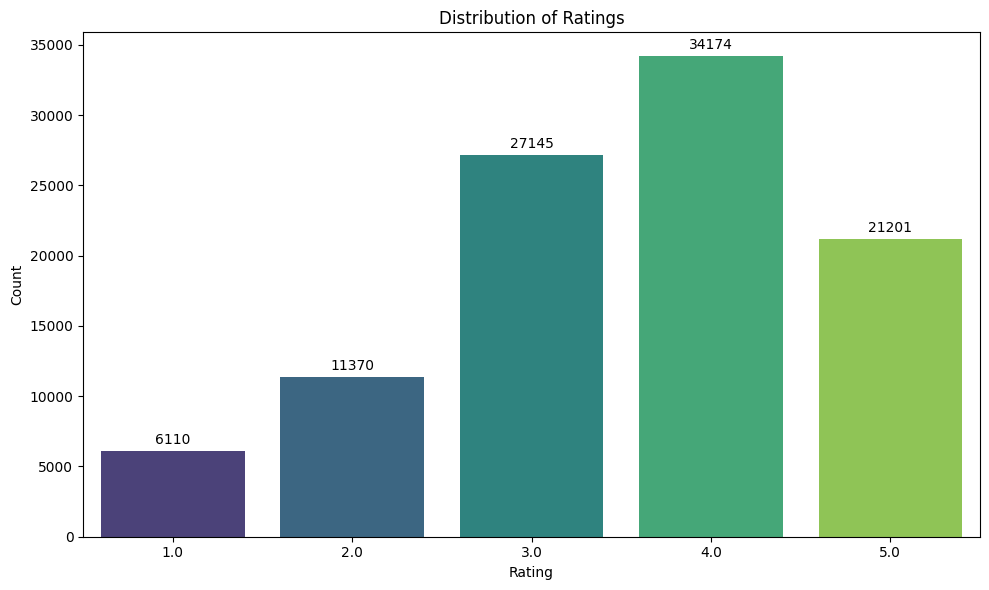

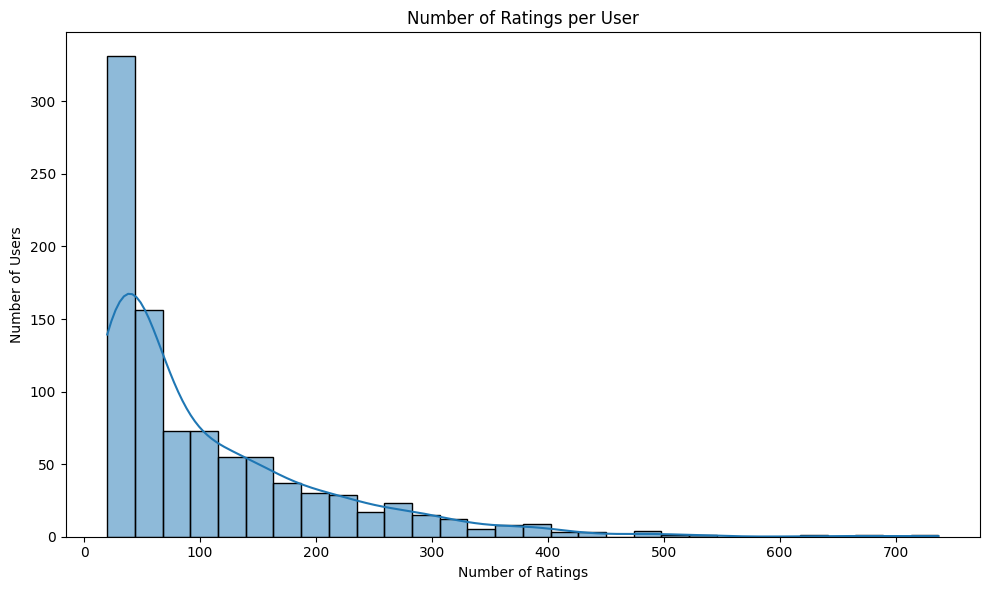

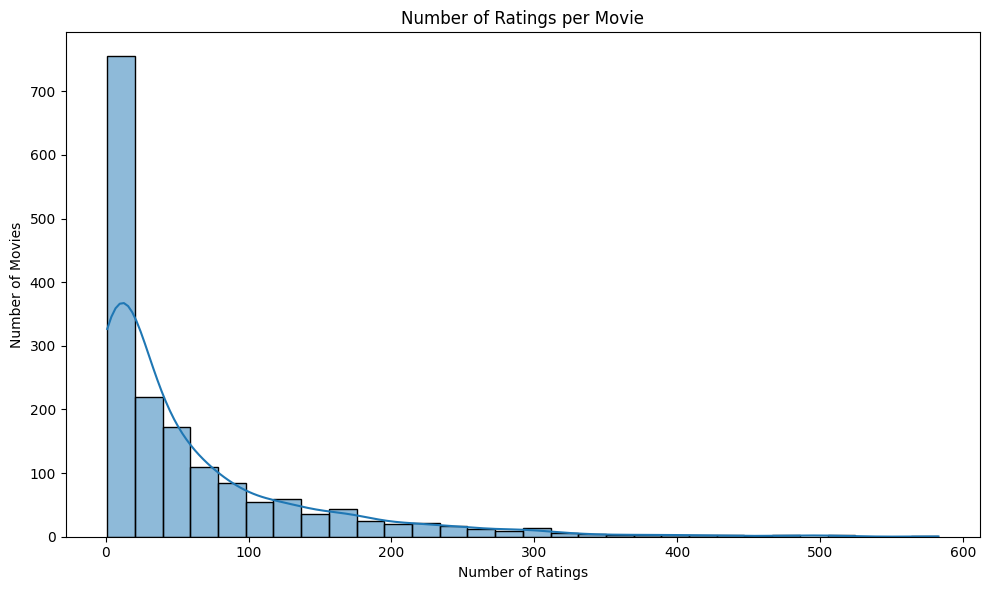

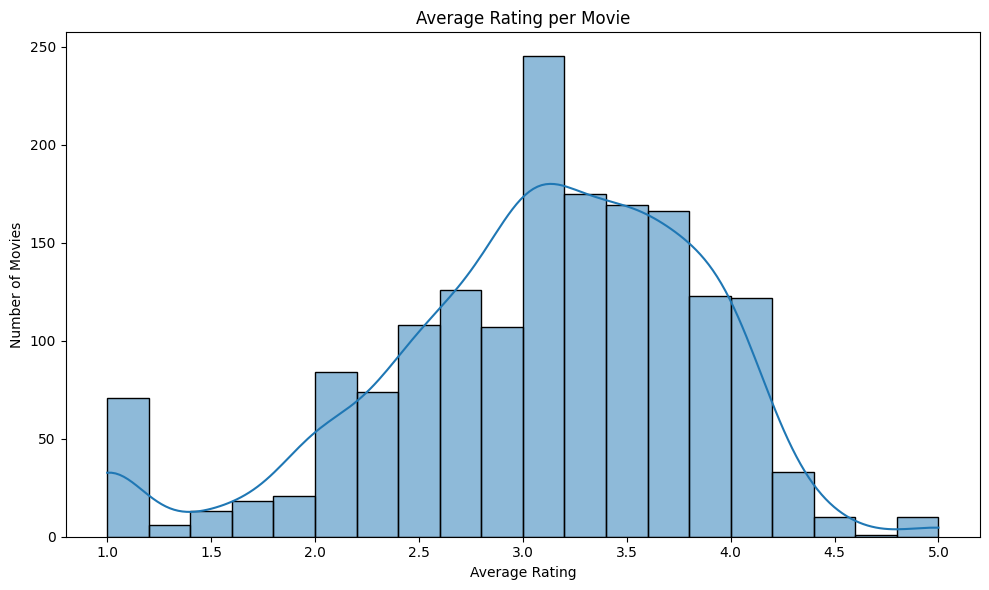


Dataset Statistics:
Total number of ratings: 100000
Number of users: 943
Number of movies: 1682
Rating range: 1.0 to 5.0
Average rating: 3.53
Most active user has 737 ratings
Most rated movie has 583 ratings
Sparsity: 93.70%


<ipython-input-59-2cdf689f4eb4>:179: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_rated_movies.values, y=movie_titles, palette='viridis')


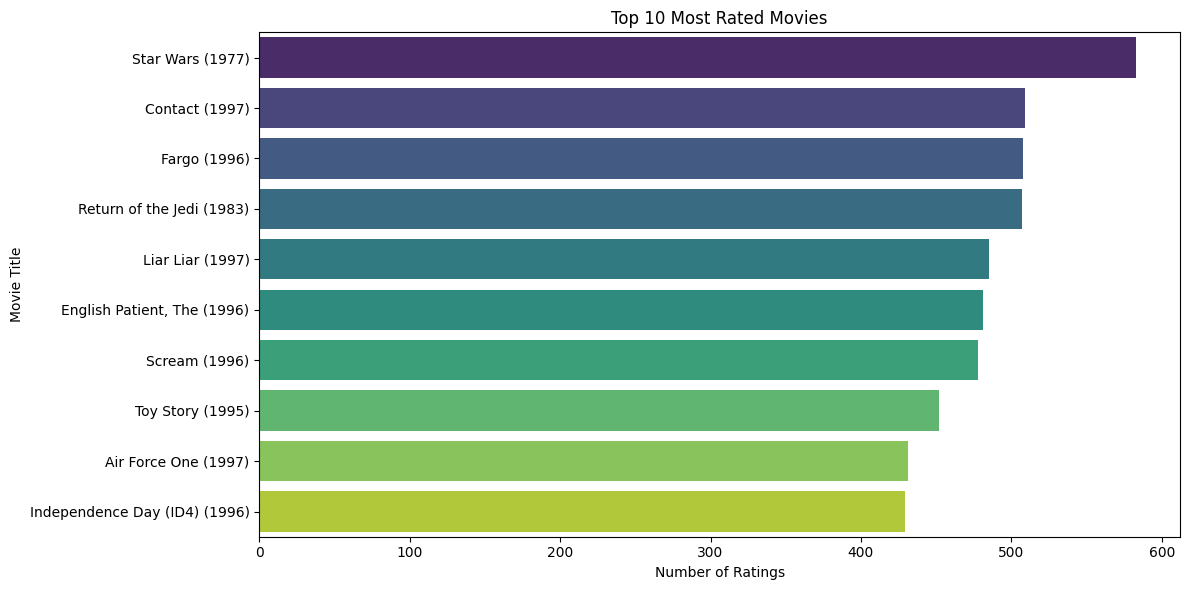

,user_id,item_id,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596
...,...,...,...,...
99995,880,476,3.0,880175444
99996,716,204,5.0,879795543
99997,276,1090,1.0,874795795
99998,13,225,2.0,882399156


In [62]:
# Analyze the dataset to understand its characteristics
analyze_dataset()

In [63]:
# When we want just the model without evaluation
algorithm, _ = train_model('svd', n_epochs=20, evaluate=False)

# Then we can evaluate separately
_, _, _, ratings_df = load_data()  # Load data for evaluation
metrics = evaluate_recommender(algorithm, ratings_df, k_values=[5, 10, 15, 20], n_users=200)

Loading MovieLens 100K dataset...
Dataset has 100000 ratings from 943 users on 1682 movies
Training svd with 20 epochs...
RMSE: 0.9352
MAE:  0.7375
Training completed in 1.62 seconds
SVD - RMSE: 0.9352, MAE: 0.7375
Model saved to models/svd_model.pkl
Loading MovieLens 100K dataset...
Dataset has 100000 ratings from 943 users on 1682 movies
Evaluating model on 200 users...

Per-k Metrics:
Precision@5: 0.0568
Recall@5: 0.0224
MAP@5: 0.0115
NDCG@5: 0.0595
F1@5: 0.0322
Precision@10: 0.0553
Recall@10: 0.0481
MAP@10: 0.0168
NDCG@10: 0.0630
F1@10: 0.0514
Precision@15: 0.0498
Recall@15: 0.0682
MAP@15: 0.0195
NDCG@15: 0.0667
F1@15: 0.0576
Precision@20: 0.0474
Recall@20: 0.0841
MAP@20: 0.0216
NDCG@20: 0.0713
F1@20: 0.0606

Overall Metrics:
Overall Precision: 0.0553
Overall Recall: 0.0551
Overall F1: 0.0552


In [68]:
recommend_movies('svd', '196', n=10, explain=True)

Loaded model: svd
Loading MovieLens 100K dataset...
Dataset has 100000 ratings from 943 users on 1682 movies
Loading MovieLens 100K dataset...
Dataset has 100000 ratings from 943 users on 1682 movies
Successfully loaded 1682 movie titles.

Top 10 movie recommendations for User 196:
--------------------------------------------------------------------------------
Rank  Movie ID   Title
--------------------------------------------------------------------------------
1     318        Schindler's List (1993)
2     64         Shawshank Redemption, The (1994)
3     474        Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)
4     408        Close Shave, A (1995)
5     357        One Flew Over the Cuckoo's Nest (1975)
6     480        North by Northwest (1959)
7     511        Lawrence of Arabia (1962)
8     603        Rear Window (1954)
9     100        Fargo (1996)
10    513        Third Man, The (1949)

Recommendation #1: Schindler's List (1993)
Loading MovieLens 

[(1, '318', "Schindler's List (1993)", 4.643424313713488),
 (2, '64', 'Shawshank Redemption, The (1994)', 4.605961892294713),
 (3,
  '474',
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)',
  4.578762463473863),
 (4, '408', 'Close Shave, A (1995)', 4.555357511409159),
 (5, '357', "One Flew Over the Cuckoo's Nest (1975)", 4.537785264491893),
 (6, '480', 'North by Northwest (1959)', 4.512972284119157),
 (7, '511', 'Lawrence of Arabia (1962)', 4.500572169683164),
 (8, '603', 'Rear Window (1954)', 4.4856823712198075),
 (9, '100', 'Fargo (1996)', 4.484789900487661),
 (10, '513', 'Third Man, The (1949)', 4.449328913322934)]